In [11]:
%pip install scipy
%pip install ripser gudhi
%pip install scikit-tda
%pip install numpy
%pip install tqdm
%pip install networkx
%pip install persim
%pip install pot

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Preprocessing

In [ ]:
from src.preprocessing.preprocessing import *

import numpy as np
from scipy.io import loadmat
import re

def load_data_from_mat(mat_dir):
    mats = []
    X = []
    y = []

    for file in os.listdir(mat_dir):
        if file.endswith(".mat"):
            mats.append(file)
    mats.sort()

    pattern = r'_([a-zA-Z]+)\d+\.mat'
    for i in range(len(mats)):        
        mat = loadmat(mat_dir + mats[i])
        X.append(mat["dm"])
        class_name = re.search(pattern, mats[i])
        
        if class_name:
            y.append(class_name.group(1))
            print(f"added {class_name.group(1)}")
        
    X = np.stack(X)
    return X, y

VR persistence diagram with Ripser

In [ ]:
import os
from src.shape.shape import *
from tqdm.notebook import tqdm
# Load preprocessed data

data_path = "data/preprocessed/geodesic/"
shape_paths = []
for file in os.listdir(data_path):
    if file.endswith(".mat"):
        shape_paths.append(data_path + file)
shape_paths.sort()
print(f"Found {len(shape_paths)} shapes... {shape_paths[0], shape_paths[1]}, ...")

shapes = []
for f in tqdm(shape_paths, desc="Loading shapes"):
    shapes.append(load_from_mat(f))
    
print(f"Loaded {len(shapes)} shapes... {shapes[0], shapes[1]}, ...")


# Load Euclidean Preprocessed data
data_path = "data/preprocessed_euclidean/euclidean/"
euclidean_shape_paths = []
for file in os.listdir(data_path):
    if file.endswith(".mat"):
        euclidean_shape_paths.append(data_path + file)

print(f"Found {len(euclidean_shape_paths)} shapes... {euclidean_shape_paths[0], euclidean_shape_paths[1]}, ...")

euclidean_shapes = []
for f in tqdm(euclidean_shape_paths, desc="Loading shapes"):
    euclidean_shapes.append(load_from_mat(f))

Found 148 shapes... ('data/preprocessed/geodesic/pre_geodesic_cat0.mat', 'data/preprocessed/geodesic/pre_geodesic_cat1.mat'), ...


Loading shapes:   0%|          | 0/148 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
shape_1 = euclidean_shapes[0]
print(shape_1.coordinates)

NameError: name 'euclidean_shapes' is not defined

### Visualize

In [ ]:
import os
from src.shape.shape import *
from tqdm.notebook import tqdm
# Load preprocessed data
coord_path = "data/preprocessing_with_coord/geodesic"
coord_shape_paths = []
for file in os.listdir(coord_path):
    if file.endswith(".mat"):
        coord_shape_paths.append(coord_path + "/" + file)
coord_shape_paths.sort()
print(f"Found {len(coord_shape_paths)} shapes... {coord_shape_paths[0], coord_shape_paths[1]}, ...")

coord_shapes = []
for f in tqdm(coord_shape_paths, desc="Loading shapes"):
    coord_shapes.append(load_from_mat(f))

print(f"Loaded {len(coord_shapes)} shapes... {coord_shapes[0], coord_shapes[1]}, ...")



Found 5 shapes... ('data/preprocessing_with_coord/geodesic/pre_geodesic_cat7.mat', 'data/preprocessing_with_coord/geodesic/pre_geodesic_michael14.mat'), ...


Loading shapes:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded 5 shapes... (<src.shape.shape.Shape object at 0x28b934810>, <src.shape.shape.Shape object at 0x28b7070d0>), ...


In [ ]:
from scipy.io import loadmat
raw_shape = "/Users/youngmin/Documents/KAIST/Mathematics/Topological Data Analysis/ComputationalProject/data/nonrigid3d/cat7.mat"

cat7 = loadmat(raw_shape)
cat7_data = cat7["surface"]
cat7_data_x = cat7_data[0][0][1]
cat7_data_y = cat7_data[0][0][2]
cat7_data_z = cat7_data[0][0][3]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

from mayavi import mlab
# Create a new figure
mlab.figure(bgcolor=(0, 0, 0))  # You can choose a background color

# Points3D plot
points = mlab.points3d(cat7_data_x, cat7_data_y, cat7_data_z, cat7_data_z, colormap='viridis', scale_mode='none', scale_factor=1.2)

# Enhancements like axes, labels can be added
mlab.axes()
mlab.show()




libpng warning: iCCP: known incorrect sRGB profile


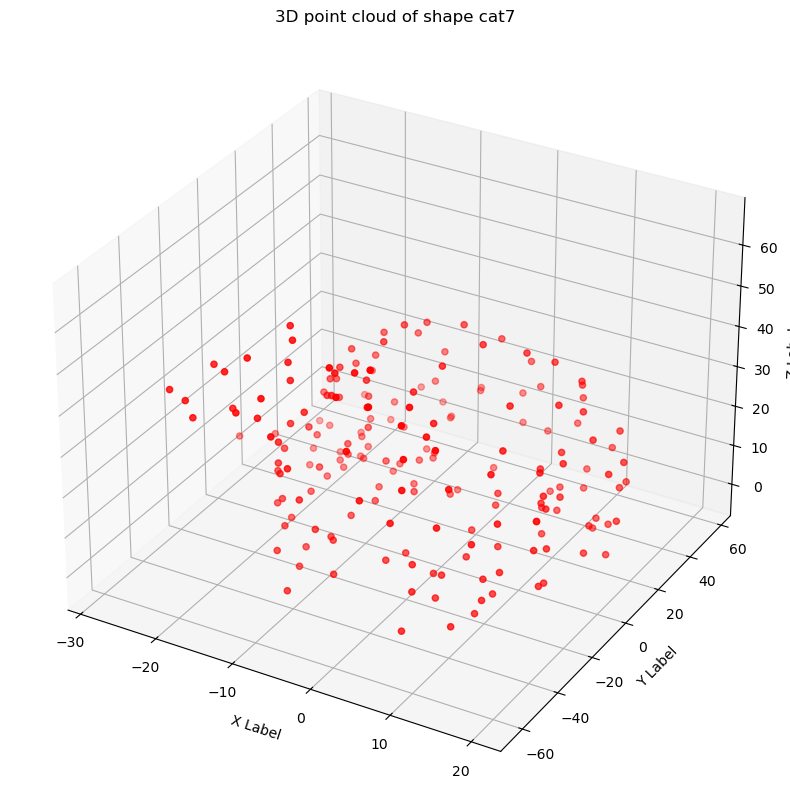

In [ ]:
# visualize 3D point cloud
shape_0 = coord_shapes[0]
shape_0.coordinates.shape

x = shape_0.coordinates[:, 0]
y = shape_0.coordinates[:, 1]
z = shape_0.coordinates[:, 2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title(f"3D point cloud of shape {shape_0.name}")
plt.show()

# Create a new figure
mlab.figure(bgcolor=(0, 0, 0))  # You can choose a background color

# Points3D plot
points = mlab.points3d(x, y, z, z, colormap='viridis', scale_mode='none', scale_factor=1.2)

# Enhancements like axes, labels can be added
mlab.axes()
mlab.show()



In [ ]:
# Load distance matrix and labels
import numpy as np
from scipy.io import loadmat
import re

def load_data_from_mat(mat_dir):
    mats = []
    X = []
    y = []

    for file in os.listdir(mat_dir):
        if file.endswith(".mat"):
            mats.append(file)
    mats.sort()

    pattern = r'_([a-zA-Z]+)\d+\.mat'
    for i in range(len(mats)):        
        mat = loadmat(mat_dir + mats[i])
        X.append(mat["dm"])
        class_name = re.search(pattern, mats[i])
        
        if class_name:
            y.append(class_name.group(1))
            print(f"added {class_name.group(1)}")
        
    X = np.stack(X)
    return X, y

euclidean_dataset_dir = "data/preprocessed_euclidean/euclidean/"
geodesic_dataset_dir = "data/preprocessing/geodesic/"

X_euclidean, y_euclidean = load_data_from_mat(euclidean_dataset_dir)
X_geodesic, y_geodesic = load_data_from_mat(geodesic_dataset_dir)

print(f"X_euclidean shape: {X_euclidean.shape}")
print(f"X_geodesic shape: {X_geodesic.shape}")

print(f"y_euclidean shape: {len(y_euclidean)}")
print(f"y_geodesic shape: {len(y_geodesic)}")

# save to csv
np.savetxt("data/cl_data/X_euclidean.csv", X_euclidean.reshape(X_euclidean.shape[0], -1), delimiter=",")
np.savetxt("data/cl_data/X_geodesic.csv", X_geodesic.reshape(X_geodesic.shape[0], -1), delimiter=",")
np.savetxt("data/cl_data/y_euclidean.csv", y_euclidean, delimiter=",", fmt="%s")
np.savetxt("data/cl_data/y_geodesic.csv", y_geodesic, delimiter=",", fmt="%s")


added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added centaur
added centaur
added centaur
added centaur
added centaur
added centaur
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added lioness
added lioness
added lion

In [ ]:
from tqdm.notebook import tqdm
dDiam_matrix = np.zeros((len(shapes), len(shapes)))


tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing dDiam matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        dDiam_matrix[i,j] = dDiam(shapes[i], shapes[j])
        dDiam_matrix[j,i] = dDiam_matrix[i,j]
        tqdm_bar.update(1)



Computing dDiam matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

Found 12 classes
Shape: cat, mean_between_cluster_distance: 79.93458925932161, mean_within_cluster_distance: 42.08108505102478, std_between_cluster_distance: 69.3240198622121, std_within_cluster_distance: 38.47889282658927
Shape: centaur, mean_between_cluster_distance: 78.90153618781379, mean_within_cluster_distance: 39.70723729027932, std_between_cluster_distance: 55.67828582099653, std_within_cluster_distance: 35.71281919717029
Shape: david, mean_between_cluster_distance: 73.28449349638785, mean_within_cluster_distance: 50.11598806333462, std_between_cluster_distance: 62.74131150309903, std_within_cluster_distance: 37.29003237021507
Shape: dog, mean_between_cluster_distance: 73.60998045871649, mean_within_cluster_distance: 27.334037425365185, std_between_cluster_distance: 65.1518298437866, std_within_cluster_distance: 23.215377232654745
Shape: gorilla, mean_between_cluster_distance: 68.35455870647833, mean_within_cluster_distance: 42.56438601195444, std_between_cluster_distance: 59.4

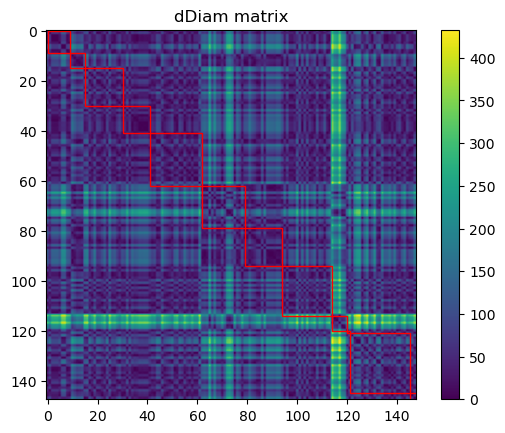

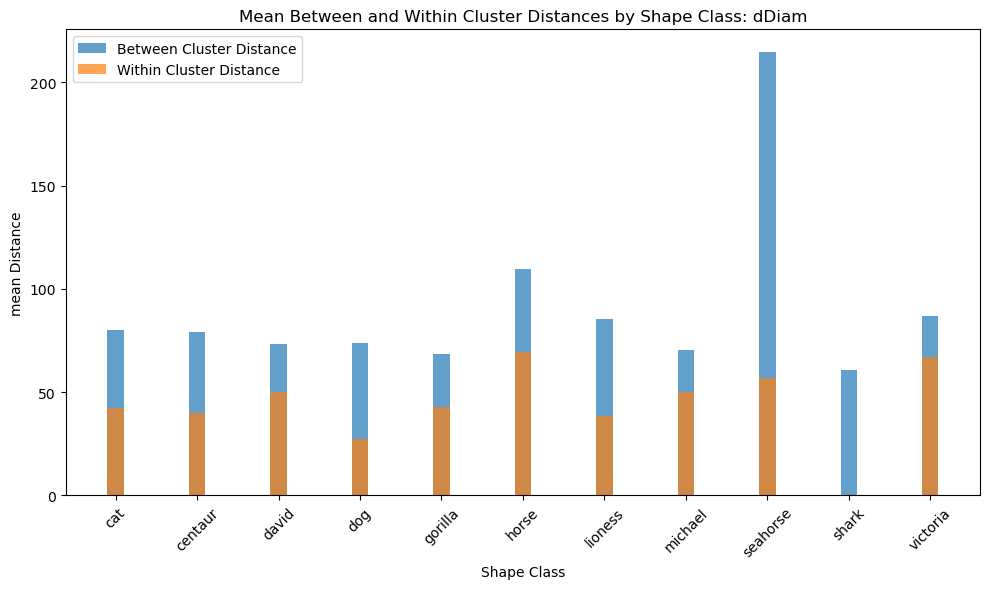

   shape_class  mean_between_cluster_distance  mean_within_cluster_distance  \
0          cat                      79.934589                     42.081085   
1      centaur                      78.901536                     39.707237   
2        david                      73.284493                     50.115988   
3          dog                      73.609980                     27.334037   
4      gorilla                      68.354559                     42.564386   
5        horse                     109.447056                     69.601701   
6      lioness                      85.610274                     38.451101   
7      michael                      70.533863                     50.237540   
8     seahorse                     214.871834                     56.799647   
9        shark                      60.591854                      0.000000   
10    victoria                      86.602310                     67.044047   

    std_between_cluster_distance  std_within_cluste

In [ ]:
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

y_df = pd.DataFrame({"y": y_geodesic})
num_classes = y_df['y'].nunique()
print(f"Found {num_classes} classes")

def plot_distance_matrix(distance_matrix, distance_name):
    plt.imshow(distance_matrix)

    start = 0
    curr=0
    shape_classes = []
    mean_between_cluster_distances = []
    mean_within_cluster_distances = []
    std_between_cluster_distances = []
    std_within_cluster_distances = []
    for i in range(len(y_df)):
        if y_df['y'][i] != y_df['y'][start]:
            box_x = start
            box_y = start
            box_width = i - start
            box_height = i - start
            box = Rectangle((box_x , box_y ), box_width, box_height, fill=False, color='red', linewidth=1)
            plt.gca().add_patch(box)
            
            
            between_cluster_distances = np.concatenate([distance_matrix[start:i, :i], distance_matrix[start:i, i:]], axis = 1)
            mean_between_cluster_distance = np.mean(between_cluster_distances)
            std_between_cluster_distance = np.std(between_cluster_distances)
            within_cluster_distances = distance_matrix[start:i, start:i]
            mean_within_cluster_distance = np.mean(within_cluster_distances)
            std_within_cluster_distance = np.std(within_cluster_distances)
            print(f"Shape: {y_df['y'][start]}, mean_between_cluster_distance: {mean_between_cluster_distance}, mean_within_cluster_distance: {mean_within_cluster_distance}, std_between_cluster_distance: {std_between_cluster_distance}, std_within_cluster_distance: {std_within_cluster_distance}")
            
            shape_classes.append(y_df['y'][start])
            mean_between_cluster_distances.append(mean_between_cluster_distance)
            mean_within_cluster_distances.append(mean_within_cluster_distance)
            std_between_cluster_distances.append(std_between_cluster_distance)
            std_within_cluster_distances.append(std_within_cluster_distance)
            
            start = i

    box_x = start
    box_y = start
    box_width = len(y_df) - start
    box_height = len(y_df) - start
    box = Rectangle((box_x , box_y ), box_width, box_height, fill=False, color='red', linewidth=1)
    plt.gca().add_patch(box)

    plt.colorbar()
    plt.title(distance_name + " matrix")
    plt.savefig(distance_name + "_matrix.png")
    plt.show()

    np.savetxt("data/" +distance_name+"_heatmap.csv", distance_matrix, delimiter=",")


    distance_mean_df = pd.DataFrame({"shape_class": shape_classes, 
    "mean_between_cluster_distance": mean_between_cluster_distances, 
    "mean_within_cluster_distance": mean_within_cluster_distances,
    "std_between_cluster_distance": std_between_cluster_distances,
    "std_within_cluster_distance": std_within_cluster_distances})
    distance_mean_df.to_csv(f"data/_{distance_name}_mean_distances.csv")
    return distance_mean_df


def report_distance_matrix(distance_mean_df, distance_name):        
    plt.figure(figsize=(10, 6))
    plt.bar(distance_mean_df['shape_class'], distance_mean_df['mean_between_cluster_distance'], 0.2,label='Between Cluster Distance', alpha=0.7,)
    plt.bar(distance_mean_df['shape_class'], distance_mean_df['mean_within_cluster_distance'], 0.2, label='Within Cluster Distance', alpha=0.7)

    plt.xlabel('Shape Class')
    plt.ylabel('mean Distance')
    plt.title(f'Mean Between and Within Cluster Distances by Shape Class: {distance_name}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()
    print(distance_mean_df)


# plot dDiam matrix
import matplotlib.pyplot as plt
mean_df = plot_distance_matrix(dDiam_matrix, "dDiam")
report_distance_matrix(mean_df, "dDiam")

In [ ]:
d_E_inf_matrix = np.zeros((len(shapes), len(shapes)))

tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing d_E_inf matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        d_E_inf_matrix[i,j] = d_E_inf(euclidean_shapes[i], euclidean_shapes[j])
        d_E_inf_matrix[j,i] = d_E_inf_matrix[i,j]
        tqdm_bar.update(1)



Computing d_E_inf matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

Shape: cat, mean_between_cluster_distance: 43.6740139649437, mean_within_cluster_distance: 38.2166173958484, std_between_cluster_distance: 22.920365692562065, std_within_cluster_distance: 22.33859690321599
Shape: centaur, mean_between_cluster_distance: 61.03725691904893, mean_within_cluster_distance: 60.603143797980415, std_between_cluster_distance: 30.43214510350174, std_within_cluster_distance: 38.44687715352949
Shape: david, mean_between_cluster_distance: 43.7566446133562, mean_within_cluster_distance: 39.96803073671129, std_between_cluster_distance: 22.30052071184307, std_within_cluster_distance: 20.55217896256933
Shape: dog, mean_between_cluster_distance: 48.494893992855154, mean_within_cluster_distance: 47.06871597037828, std_between_cluster_distance: 24.658027489488504, std_within_cluster_distance: 28.405312647805474
Shape: gorilla, mean_between_cluster_distance: 48.22079593717975, mean_within_cluster_distance: 48.570912951514835, std_between_cluster_distance: 26.16453829015115,

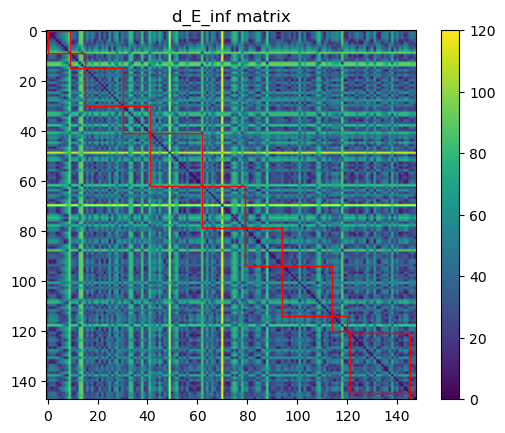

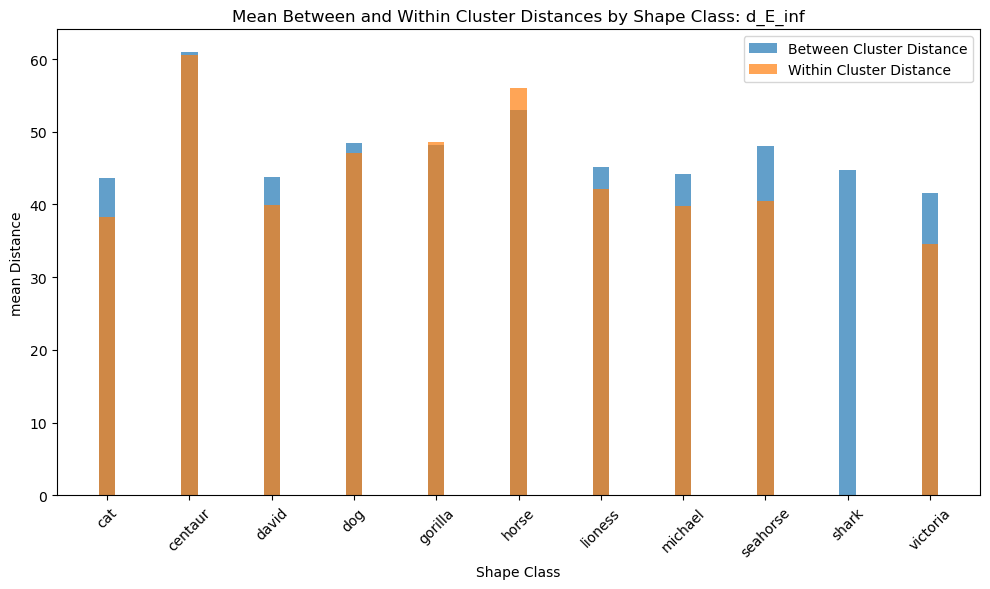

   shape_class  mean_between_cluster_distance  mean_within_cluster_distance  \
0          cat                      43.674014                     38.216617   
1      centaur                      61.037257                     60.603144   
2        david                      43.756645                     39.968031   
3          dog                      48.494894                     47.068716   
4      gorilla                      48.220796                     48.570913   
5        horse                      52.954630                     56.077048   
6      lioness                      45.210829                     42.120564   
7      michael                      44.208234                     39.820521   
8     seahorse                      48.092704                     40.538193   
9        shark                      44.720723                      0.000000   
10    victoria                      41.635830                     34.563939   

    std_between_cluster_distance  std_within_cluste

In [ ]:
# plot distance matrix
mean_df = plot_distance_matrix(d_E_inf_matrix, "d_E_inf")
report_distance_matrix(mean_df, "d_E_inf")

In [ ]:
d_G_1_matrix = np.zeros((len(shapes), len(shapes)))
d_G_inf_matrix = np.zeros((len(shapes), len(shapes)))

tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing d_G_1 and g_G_inf matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        d_G_1_matrix[i,j] = d_G_wasserstein(shapes[i], shapes[j], q=1)
        d_G_inf_matrix[i,j] = d_G_wasserstein(shapes[i], shapes[j], q=np.inf)
        d_G_1_matrix[j,i] = d_G_1_matrix[i,j]
        d_G_inf_matrix[j,i] = d_G_inf_matrix[i,j]
        tqdm_bar.update(1)




Computing d_G_1 and g_G_inf matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
mean_df_d_G_1 = plot_distance_matrix(d_G_1_matrix, "d_G_1")
mean_df_d_G_inf = plot_distance_matrix(d_G_inf_matrix, "d_G_inf")

report_distance_matrix(mean_df_d_G_1, "d_G_1")
report_distance_matrix(mean_df_d_G_inf, "d_G_inf")

In [ ]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(d_G_1_matrix)
plt.colorbar()
plt.title("d_G_1 matrix")
plt.subplot(1,2,2)
plt.imshow(d_G_inf_matrix)
plt.colorbar()
plt.title("d_G_inf matrix")
plt.savefig("d_G_matrix.png")
plt.show()


In [ ]:
from src.shape import *
dG_inf_bottleneck_matrix = np.zeros((len(shapes), len(shapes)))

for i in tqdm(range(len(shapes)), desc="Computing dG_inf_bottleneck matrix"):
    for j in range(i+1, len(shapes)):
        dG_inf_bottleneck_matrix[i,j] = d_G_bottleneck(shapes[i], shapes[j])
        dG_inf_bottleneck_matrix[j,i] = dG_inf_bottleneck_matrix[i,j]

In [ ]:
plot_distance_matrix(dG_inf_bottleneck_matrix, "dG_inf_bottleneck")
report_distance_matrix(mean_df_d_G_inf, "dG_inf_bottleneck")


### Evaluate the distance matrix using classification

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

class Classifier:
    def __init__(self, distance_matrix, X_train, y_train):
        self.distance_matrix = distance_matrix
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for i in range(len(X_test)):
            distances = self.distance_matrix[i, :]
            min_index = np.argmin(distances)
            y_pred.append(self.y_train[min_index])
        return y_pred


def split_dataset(X, y, testset_portion = 0.1, k_fold= False, random_state=123):
    if k_fold:
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        return skf.split(X, y)
    else:
        return train_test_split(X, y, test_size=testset_portion, random_state=random_state, stratify=y)

def evaluate(y_test, y_pred):
    for i in range(len(y_test)):
        if y_test[i] != y_pred[i]:
            print(f"y_test: {y_test[i]}, y_pred: {y_pred[i]}")

    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, cm

def evaluate_distance_matrix(distance_matrix, X, y, k_fold = False, test_portion = 0.1, num_splits = 10):
    if k_fold:
        skf = StratifiedKFold(n_splits=num_splits, shuffle=True)
        splits = skf.split(X, y)
        accuracies = []
        cms = []
        
        for train_index, test_index in splits:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            classifier = Classifier(distance_matrix, X_train, y_train)
            y_pred = classifier.predict(X_test)
            
            accuracy, cm = evaluate(y_test, y_pred)
            accuracies.append(accuracy)
            cms.append(cm)
        return np.mean(accuracies) , accuracies, cms
    else:
        accuracies = []
        cms = []
        for i in range(num_splits):
            X_train, X_test, y_train, y_test = split_dataset(X, y, testset_portion=test_portion)
            classifier = Classifier(distance_matrix, X_train, y_train)
            y_pred = classifier.predict(X_test)

            accuracy, cm = evaluate(y_test, y_pred)
            accuracies.append(accuracy)
            cms.append(cm)
        return np.mean(accuracies) , accuracies, cms


In [ ]:
# remove shark from dataset

# find shark
ind = np.where(y_geodesic == "shark")[0].item()

# remove shark
X_geodesic = np.delete(X_geodesic, ind, axis=0)
y_geodesic = np.delete(y_geodesic, ind, axis=0)

X_euclidean = np.delete(X_euclidean, ind, axis=0)
y_euclidean = np.delete(y_euclidean, ind, axis=0)


In [ ]:
mean_acc_dDiam, accuracies_dDiam, cms_dDiam = evaluate_distance_matrix(dDiam_matrix, X_geodesic, y_geodesic, k_fold=True, num_splits=10)
mean_acc_d_E_inf, accuracies_d_E_inf, cms_d_E_inf = evaluate_distance_matrix(d_E_inf_matrix, X_euclidean, y_euclidean, k_fold=True, num_splits=10)
mean_acc_d_G_1, accuracies_d_G_1, cms_d_G_1 = evaluate_distance_matrix(d_G_1_matrix, X_geodesic, y_geodesic, k_fold=True, num_splits=10)
mean_acc_d_G_inf, accuracies_d_G_inf, cms_d_G_inf = evaluate_distance_matrix(d_G_inf_matrix, X_geodesic, y_geodesic, k_fold=True, num_splits=10)

# draw box plot.
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    "dDiam": accuracies_dDiam,
    "d_E_inf": accuracies_d_E_inf,
    "d_G_1": accuracies_d_G_1,
    "d_G_inf": accuracies_d_G_inf
}
df = pd.DataFrame(data)
sns.boxplot(data=df)
plt.title("Box plot of accuracies")
plt.xlabel("Distance matrix")
plt.ylabel("Accuracy")
plt.show()
plt.savefig("boxplot.png")

print(f"mean_acc_dDiam: {mean_acc_dDiam}")
print(f"mean_acc_d_E_inf: {mean_acc_d_E_inf}")
print(f"mean_acc_d_G_1: {mean_acc_d_G_1}")
print(f"mean_acc_d_G_inf: {mean_acc_d_G_inf}")

### Dendrogram

In [ ]:
from scipy.cluster.hierarchy import single, dendrogram, complete
from scipy.spatial.distance import squareform

converted_d_G_1_matrix = squareform(d_G_1_matrix, checks= False)
converted_d_G_inf_matrix = squareform(d_G_inf_matrix, checks= False)
converted_d_E_inf_matrix = squareform(d_E_inf_matrix, checks= False)

linked_d_G_1 = single(converted_d_G_1_matrix)
linked_d_G_inf = single(converted_d_G_inf_matrix)
linked_d_E_inf = single(converted_d_E_inf_matrix)

plt.figure(0, figsize=(20, 7))
dendrogram(linked_d_G_1, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_1 dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_1_dendrogram.png")
plt.show()

plt.figure(1, figsize=(20, 7))
dendrogram(linked_d_G_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_inf_dendrogram.png")
plt.show()

plt.figure(2, figsize=(20, 7))
dendrogram(linked_d_E_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels = y_euclidean, leaf_font_size=10)
plt.title("d_E_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_E_inf_dendrogram.png")
plt.show()


### Complete Linkage

In [ ]:
from scipy.cluster.hierarchy import single, dendrogram, complete
from scipy.spatial.distance import squareform

linked_d_G_1 = complete(converted_d_G_1_matrix)
linked_d_G_inf = complete(converted_d_G_inf_matrix)
linked_d_E_inf = complete(converted_d_E_inf_matrix)

plt.figure(0, figsize=(20, 7))
dendrogram(linked_d_G_1, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_1 dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_1_dendrogram.png")
plt.show()

plt.figure(1, figsize=(20, 7))
dendrogram(linked_d_G_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_inf_dendrogram.png")
plt.show()

plt.figure(2, figsize=(20, 7))
dendrogram(linked_d_E_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels = y_euclidean, leaf_font_size=10)
plt.title("d_E_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_E_inf_dendrogram.png")
plt.show()

## Multidimensional scaling Plot

In [ ]:
from sklearn.manifold import MDS

mds_d_G_1 = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
mds_d_G_inf = MDS(n_components=2, dissimilarity="precomputed", random_state=0)

mds_result_d_G_1 = mds_d_G_1.fit_transform(d_G_1_matrix)
mds_result_d_G_inf = mds_d_G_inf.fit_transform(d_G_inf_matrix)

plt.figure(0, figsize=(15, 7))
plt.scatter(mds_result_d_G_1[:,0], mds_result_d_G_1[:,1], c='blue', marker = 'o')
plt.title("d_G_1 MDS")
plt.show()

plt.figure(1, figsize=(15, 7))
plt.scatter(mds_result_d_G_inf[:,0], mds_result_d_G_inf[:,1], c='blue', marker = 'o')
plt.title("d_G_inf MDS")
plt.show()


### Baselines for classification: Logistic regression, SVM, Random Forest on the distance matrix

Using the same train and test set, we will compare the performance of the baseline models. And compare the classfication using dDiam and other dissimilarity measures.

TODO: use PCA before Logistic regression, SVM, RF on the distance matrix due to the high dimensionality of the distance matrix and the small sample size. 

1. Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_euclidean = np.loadtxt("data/cl_data/X_euclidean.csv", delimiter=",")
X_geodesic = np.loadtxt("data/cl_data/X_geodesic.csv", delimiter=",")
y_euclidean = np.loadtxt("data/cl_data/y_euclidean.csv", delimiter=",", dtype=str)
y_geodesic = np.loadtxt("data/cl_data/y_geodesic.csv", delimiter=",", dtype=str)

print(f"X_euclidean shape: {X_euclidean.shape}")
print(f"X_geodesic shape: {X_geodesic.shape}")

print(f"y_euclidean shape: {len(y_euclidean)}")
print(f"y_geodesic shape: {len(y_geodesic)}")

X_euclidean_train, X_euclidean_test, y_euclidean_train, y_euclidean_test = train_test_split(X_euclidean, y_euclidean, test_size=0.2, random_state=42)
X_geodesic_train, X_geodesic_test, y_geodesic_train, y_geodesic_test = train_test_split(X_geodesic, y_geodesic, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_euclidean_train = scaler.fit_transform(X_euclidean_train)
X_euclidean_test = scaler.transform(X_euclidean_test)

X_geodesic_train = scaler.fit_transform(X_geodesic_train)
X_geodesic_test = scaler.transform(X_geodesic_test)

clf_euclidean = LogisticRegression(random_state=0).fit(X_euclidean_train, y_euclidean_train)
clf_geodesic = LogisticRegression(random_state=0).fit(X_geodesic_train, y_geodesic_train)

y_euclidean_pred = clf_euclidean.predict(X_euclidean_test)
y_geodesic_pred = clf_geodesic.predict(X_geodesic_test)

print(f"Euclidean accuracy: {accuracy_score(y_euclidean_test, y_euclidean_pred)}")
print(f"Geodesic accuracy: {accuracy_score(y_geodesic_test, y_geodesic_pred)}")

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm_euclidean = confusion_matrix(y_euclidean_test, y_euclidean_pred)
cm_geodesic = confusion_matrix(y_geodesic_test, y_geodesic_pred)

plt.figure(0)
plt.imshow(cm_euclidean)
plt.colorbar()
plt.title("Euclidean confusion matrix")
plt.savefig("euclidean_confusion_matrix.png")
plt.show()

plt.figure(1)
plt.imshow(cm_geodesic)
plt.colorbar()
plt.title("Geodesic confusion matrix")
plt.savefig("geodesic_confusion_matrix.png")
plt.show()

print(classification_report(y_euclidean_test, y_euclidean_pred))
print(classification_report(y_geodesic_test, y_geodesic_pred))

2. SVM

In [ ]:
from sklearn.svm import SVC

clf_euclidean = SVC(random_state=0).fit(X_euclidean_train, y_euclidean_train)
clf_geodesic = SVC(random_state=0).fit(X_geodesic_train, y_geodesic_train)

y_euclidean_pred = clf_euclidean.predict(X_euclidean_test)
y_geodesic_pred = clf_geodesic.predict(X_geodesic_test)

print(f"Euclidean accuracy: {accuracy_score(y_euclidean_test, y_euclidean_pred)}")
print(f"Geodesic accuracy: {accuracy_score(y_geodesic_test, y_geodesic_pred)}")

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm_euclidean = confusion_matrix(y_euclidean_test, y_euclidean_pred)
cm_geodesic = confusion_matrix(y_geodesic_test, y_geodesic_pred)

plt.figure(0)
plt.imshow(cm_euclidean)
plt.colorbar()
plt.title("Euclidean confusion matrix")
plt.savefig("euclidean_confusion_matrix.png")
plt.show()

plt.figure(1)
plt.imshow(cm_geodesic)
plt.colorbar()
plt.title("Geodesic confusion matrix")
plt.savefig("geodesic_confusion_matrix.png")
plt.show()

print(classification_report(y_euclidean_test, y_euclidean_pred))
print(classification_report(y_geodesic_test, y_geodesic_pred))

3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_euclidean = RandomForestClassifier(random_state=0).fit(X_euclidean_train, y_euclidean_train)
clf_geodesic = RandomForestClassifier(random_state=0).fit(X_geodesic_train, y_geodesic_train)

y_euclidean_pred = clf_euclidean.predict(X_euclidean_test)
y_geodesic_pred = clf_geodesic.predict(X_geodesic_test)

print(f"Euclidean accuracy: {accuracy_score(y_euclidean_test, y_euclidean_pred)}")
print(f"Geodesic accuracy: {accuracy_score(y_geodesic_test, y_geodesic_pred)}")

cm_euclidean = confusion_matrix(y_euclidean_test, y_euclidean_pred)
cm_geodesic = confusion_matrix(y_geodesic_test, y_geodesic_pred)

plt.figure(0)
plt.imshow(cm_euclidean)
plt.colorbar()
plt.title("Euclidean confusion matrix")
plt.savefig("euclidean_confusion_matrix.png")
plt.show()

plt.figure(1)
plt.imshow(cm_geodesic)
plt.colorbar()
plt.title("Geodesic confusion matrix")
plt.savefig("geodesic_confusion_matrix.png")
plt.show()

print(classification_report(y_euclidean_test, y_euclidean_pred))
print(classification_report(y_geodesic_test, y_geodesic_pred))

### Classification using dDiam

In [ ]:
# 1. dendrogram

from scipy.cluster.hierarchy import single, dendrogram
from scipy.spatial.distance import squareform

converted_d_diam_matrix = squareform(dDiam_matrix, checks= False)

linked_d_diam = complete(converted_d_diam_matrix)

plt.figure(0, figsize=(15, 7))
dendrogram(linked_d_diam, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic)
plt.title("dDiam dendrogram")

plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("dDiam_dendrogram.png")
plt.show()

In [ ]:
# 2. k-means with exact K-value (k=12)
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

kmeans = KMeans(n_clusters=12, random_state=0).fit(dDiam_matrix)
labels = kmeans.labels_

y_geodesic_encoded = LabelEncoder().fit_transform(y_geodesic)



print(f"Silhouette score: {silhouette_score(dDiam_matrix, labels)}")
print(f"Adjusted rand score: {adjusted_rand_score(y_geodesic_encoded, labels)}")

range_n_clusters = range(2,15)
silhouette_average_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(dDiam_matrix)
    labels = kmeans.labels_
    silhouette_average_scores.append(silhouette_score(dDiam_matrix, labels))
    print(f"k: {k}, silhouette score: {silhouette_score(dDiam_matrix, labels)}")

plt.plot(range_n_clusters, silhouette_average_scores)
plt.title("Silhouette score for k-means clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.savefig("silhouette_score.png")
plt.show()

## Compare Euclidean distance and Geodesic distance

In [ ]:
# 3. k-means with estimated K-value (k=12), Sillhouette score 
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

kmeans_euc = KMeans(n_clusters=12, random_state=0).fit(d_E_inf_matrix)
labels = kmeans_euc.labels_

y_geodesic_encoded = LabelEncoder().fit_transform(y_geodesic)
y_euclidean_encoded = LabelEncoder().fit_transform(y_euclidean)

rand_euc = adjusted_rand_score(y_euclidean_encoded, labels)
sil_euc = silhouette_score(d_E_inf_matrix, labels, metric='euclidean')

kmeans_geo = KMeans(n_clusters=12, random_state=0).fit(d_G_inf_matrix)
labels = kmeans_geo.labels_

sil_geo = silhouette_score(d_G_inf_matrix, labels, metric='euclidean')
rand_geo = adjusted_rand_score(y_geodesic_encoded, labels)
print(f"Euclidean Silhouette score: {sil_euc}")
print(f"Geodesic Silhouette score: {sil_geo}")

# 4. k-means with estimated K-value (k=12), Adjusted rand score

print(f"Euclidean Adjusted rand score: {rand_euc}")
print(f"Geodesic Adjusted rand score: {rand_geo}")
